# Visualizing satellite handovers 

The Starlink gRPC api exposes a `dish_get_obstruction_map` method, following the approach described in CITE_LEO_PAPER we can use the information we gather from polling this method each second to extract the current obstruction map and visualize satellite handovers. The reason this works is the dish is adding a dot (setting a value to 1) in a 123*123 matrix whenever it sees a satellite in that position, whenever the dish is rebooted (using i.e `nine981.reboot`) the matrix is cleared by setting every entry to -1, whenever a satellite is detected entry is set. If we poll the endpoint frequently enough we can observe satellites traces, by comparing values in the matrices we obtain we can detect whether a satellite handover was performed.


$$
A_{t(x)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
B_{t(x+1)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & 1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
A+B=
\begin{bmatrix}
-2 & -2 & 2 & -2 & -2 \\
-2 & -2 & -2 & 2 & -2 \\
-2 & -2 & -2 & -2 & 0 \\
-2 & -2 & -2 & -2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
\end{bmatrix}
$$

Let's assume these matrices come from the endpoints at $t_x$ and $t_{x+1}$ respectively, in the first matrix we have ones in $(0,2)$ and $(1,3)$, in the second one we have ones in $(0,2)$, $(1,3)$, $(2,4)$, this means the new satellite we saw at $t_{x+1}$ is on the same path as the satellites before, thus NO handover was not performed.

$$
A_{t(x)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
B_{t(x+1)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
A+B
=
\begin{bmatrix}
-2 & -2 & 2 & -2 & -2 \\
-2 & -2 & -2 & 2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
0 & -2 & -2 & -2 & -2 \\
\end{bmatrix}
$$

If instead the new satellite we see at $t_{x+1}$ is in a totally different area an handover must have been performed.

We can observe it is pretty easy to detect whether an handover was performed, it is sufficient to sum the two matrices and check whether the $0$ value (there was -1 before and we currently have 1) is near an entry whose value is $2$ (at $t_{x}$ value was 1 and at $t_{x+1}$ value is $1$. 



First of all we need to write a script to extract obstruction maps from the dish, to achieve this goal we can use the `nine981.get_obstruction_map` function, this returns a json file similar to this:

```json
{'apiVersion': '9',
 'dishGetObstructionMap': {'minElevationDeg': 10.0,
                           'numCols': 123,
                           'numRows': 123,
                           'snr': [-1.0,
                                   -1.0,
                                   -1.0,
                                   1.0,
                                   1.0,
                                   -1.0,
                                   -1.0,
                                   1.0,
                                   1.0,
                                   1.0,
                                   -1.0,
                                   -1.0,
                                   -1.0,
                                   -1.0]}}
```

Thus we can simply extract the values in `map["dishGetObstructionMap"]["snr"]` and use `np.array(map).reshape(123, 123)` to reshape the array into a $123\times123$ matrix.




In [3]:
import os
import time
import nine981

directory="./obstruction_maps"
def get_obstruction_maps():
    # amount of seconds to collect maps for
    for i in range(300):
        map = nine981.get_obstruction_map()
        os.makedirs(os.path.dirname(directory + "/"), exist_ok=True)
        with open(f"{directory}/{int(time.time())}.json", "w+") as f:
            f.write(map)
        time.sleep(1)
    os.exit(0)

if __name__ == "__main__":
    get_obstruction_maps()

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.DEADLINE_EXCEEDED
	details = "Deadline Exceeded"
	debug_error_string = "UNKNOWN:Deadline Exceeded {created_time:"2023-08-15T16:19:19.89918+02:00", grpc_status:4}"
>

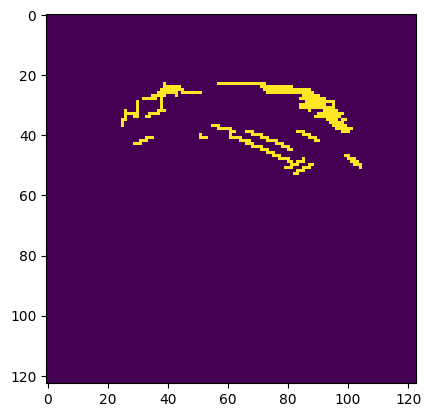

In [2]:

import json
import numpy as np
import matplotlib.pyplot as plt

f1 = "/Users/rc/idp-castellotti-data/map-bw-stuff4/1692089163.json"
map = json.load(open(f1))
map = map["dishGetObstructionMap"]["snr"]
map = np.array(map1).reshape(123, 123)
plt.imshow(map)
plt.show()

[ ] mention the visualize_handover function in common
